# README from code source
## NCS

NCS is a Noise Correction Algorithm for sCMOS cameras.

## Abstract
Scientific CMOS (sCMOS) cameras are quickly gaining popularity in life sciences, material science and astronomy because its advantages in a much faster frame rate, larger field of view and higher detection efficiency than traditional cameras such as CCD and EMCCD. However, they introduce pixel-dependent noise that generates image artifacts and biases in quantification.

NCS (noise correction algorithm for sCMOS (CMOS) cameras) is an algorithm that minimizes sCMOS noise from microscopy images with arbitrary structures. In the citation linked below, we show our new method enables significantly reduction of the pixel-dependent noises in fluorescence microscopy using a sCMOS camera and makes its performance approaching that of an ideal camera.

## NCS source code demo
The demo package consists of functions and scripts written in Python 3.6. The code was tested using Windows7. We recommend installing Anaconda with Python 3.6 and using the Spyder Python editor. This version of the demo code is a beta version. Future versions of the code will include more documentation.

To run the demo code for simulated microtubule structure:

	1. Set the current folder in Spyder to NCS\python3-6
	2. Open script NCSdemo_simulation.py. Set the value of the following parameters: imgsz (image size), Pixelsize, NA (numerical aperture of the objective), Lambda (emission wavelength), I (photon count of each fluorophore), bg (background photon count), N (number of  images), offset (offset ADU level of the sCMOS camera), iterationN (number of iterations), alpha (weight factor of noise contribution), Rs (size of segmented image) and the type of the OTF mask (default is OTFweighted).
	3. Run the code.
	4. The output includes: imsd (sCMOS image stack), out (the noise corrected image).
	5. The computation time depends on the imgsz (image size), N (number of images), iterationN (number of iterations) and Rs (segmentation size).

### License and Citation
NCS is released under the [GNU license](https://github.com/HuanglabPurdue/NCS/edit/master/LICENSE).

Please cite NCS in your publications if it helps your research:

  	 @article{Liu2017NCS,
	Author = {Liu, Sheng and Mlodzianoski1, Michael J. and Hu, Zhenhua and Ren, Yuan and McElmurry, Kristi and Suter, Daniel M. and Huang, Fang},
	Journal = {Nature Methods},
	Title = {sCMOS noise-correction algorithm for microscopy images},
	Year = {2017}
	volume = {14}
	number = {8}
	pages = {760-761}
   }

# Pixel-wise denoising
The algorithm is based on NCS (noise correction algorithm for sCMOS (scientific CMOS) cameras) at https://github.com/HuanglabPurdue/NCS

The reference paper is as follow:
https://www.nature.com/articles/nmeth.4379

Some details of algorithms can be found at:
1. Characterization of sCMOS camera: https://media.nature.com/original/nature-assets/nmeth/journal/v10/n7/extref/nmeth.2488-S1.pdf
2. Algorithm details: https://media.nature.com/original/nature-assets/nmeth/journal/v14/n8/extref/nmeth.4379-S1.pdf

# Processing diagram
1. Correct offset and gain using pre-characterized values (some sCMOS camera manufacturers now provide these parameter maps) for each pixel to obtain a precorrected image 𝐷. Set all pixels with non-positive values in 𝐷 to a small but non-zero value such as $10^{-6}$, where $D_i =\frac{A_i - o_i}{g_i}$, $A_i$ pixel intensity, $o_i$ pixel offset, $g_i$ pixel gain.
2. Segment input image into sub-images with M by M pixels. The recommended value for M is 8~32.
3. For each segment, obtain an estimate by minimizing a cost function $f = LLS + \alpha\sigma N$ where LLS and $\sigma N$ stand for the simplified negative log-likelihood and the noise contribution near and outside the OTF periphery respectively, and **$\alpha$ is an empirical weight factor** (a small $\alpha$ results in a bad noise correction; a large \alpha results in a decrease in resolution).
4. For each segment, repeat step 3. All segments are independent and therefore can be processed in parallel through GPU or CPU. The regression converges within 20 iterations.

![](nmeth.4379-S1.jpg)


/groups/ahrens/home/weiz/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


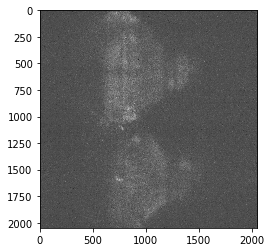

In [1]:
# load data
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import h5py
h5f = h5py.File('/groups/ahrens/ahrenslab/davis/shared/for_ziqiang/sample_stack/5dpf_cy171xcy221_f1_omr_2/TM0000000_CM0_CHN00.h5', 'r')
imgStack = h5f['default'] # z, x, y
plt.imshow(imgStack[0], cmap='gray')
exImg = imgStack[0]

In [2]:
import os, sys
fish_path = os.path.abspath(os.path.join('../..'))
if fish_path not in sys.path:
    sys.path.append(fish_path)

In [3]:
M = 32 # size of segmented image

In [4]:
# assuming 
imgsz = exImg.shape[0]# image size
assert exImg.shape[0] == exImg.shape[1], 'Please crop the image to have the same pixels on x and y'
# the number (imgsz/M)^2 small square patches will be processed in parallel

# Characterization of sCMOS camera

## Offset and variance of sCMOS camera
Offset values describe a constant level of ADUs (analog-to-digital unit) pre-engineered into the readout process in order to prevent negative ADUs caused by the readout noise. Both are estimated by performing temporally across M dark frames, e.g. $N = 60,000$. For pixel i

offset: $o_i = \frac{1}{N}\sum_{n=1}^{N}s_i^n$

variance: $v_i = \frac{1}{N}\sum_{n=1}^{N}(s_i^n)^2-o_i^2$

## Gain of sCMOS camera
To determine the gain value for each pixel the authors illuminated the camera with quasi-uniform stationary intensity patterns and recorded a series of image sequences (20,000 images in each sequence) at different average intensity levels ranging from ~20 to 200 photons per pixel (totally $K$ levels). **This is shot noise and estimated using Gaussian distribution which approximates the Poisson distribution**

$\hat{g_i} = \arg \min \sum_{k=1}^K((v_i^k-v_i)-g_i(<D_i^k>-o_i))^2$

where $<D_i^k>$ is mean ADU of all frames at level $k$, $v_i^k$ is the variance.

Let $A_i$ is a vector $\{(v_i^1 - v_i), \cdots, (v_i^K - v_i)\}$, and $B_i$ is a vector $\{(<D_i^1> - o_i), \cdots, (<D_i^K> - o_i)\}$ and $\hat{g_i} = (B_i B_i^T)^{-1}B_i A_i$.

In [39]:
import seaborn as sns
sns.set(font_scale=2)
sns.set_style("white")

In [5]:
offset = np.load('/groups/ahrens/ahrenslab/Ziqiang/gainMat/gainMat20180208/offset_mat.npy')
var = np.load('/groups/ahrens/ahrenslab/Ziqiang/gainMat/gainMat20180208/var_mat.npy')
gain = np.load('/groups/ahrens/ahrenslab/Ziqiang/gainMat/gainMat20180208/gain_mat.npy')

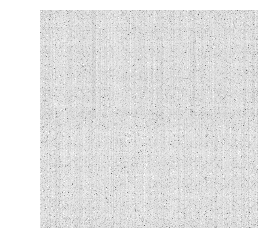

In [6]:
# offset plots, one can easily see some hotspots
plt.imshow(offset, plt.cm.gray, vmin=85, vmax=101)
plt.axis('off')
plt.savefig('offset.png', dpi=700)
plt.show()

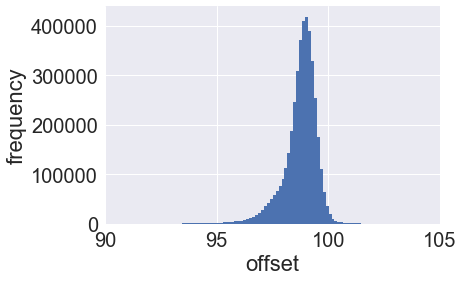

In [25]:
plt.hist(offset.flatten(), 1000)
plt.xlim([90, 105])
plt.xlabel('offset')
plt.ylabel('frequency')
plt.show()

In [13]:
(offset.flatten()<90).mean()+(offset.flatten()>105).mean()

3.9577484130859375e-05

### Compute offset, variance, and gain matrices

In [8]:
from glob import glob
offsetMat = [];
varmat = [];
for nfile in sorted(glob('/groups/ahrens/ahrenslab/davis/shared/for_ziqiang/camera_statsgain_measure*.npz')):
    print(nfile)
    data = np.load(nfile)
    tOff = data['arr_0']
    tvar = data['arr_1']
    offsetMat.append(tOff)
    varmat.append(tvar)
offsetMat = np.array(offsetMat)
varmat = np.array(varmat)
gainMatShape = (varmat.shape[1], varmat.shape[2])

/groups/ahrens/ahrenslab/davis/shared/for_ziqiang/camera_statsgain_measure_0mW_20180206_162724.npz
/groups/ahrens/ahrenslab/davis/shared/for_ziqiang/camera_statsgain_measure_10mW_20180206_174348.npz
/groups/ahrens/ahrenslab/davis/shared/for_ziqiang/camera_statsgain_measure_15mW_20180206_175509.npz
/groups/ahrens/ahrenslab/davis/shared/for_ziqiang/camera_statsgain_measure_20mW_20180206_180049.npz
/groups/ahrens/ahrenslab/davis/shared/for_ziqiang/camera_statsgain_measure_25mW_20180206_180804.npz
/groups/ahrens/ahrenslab/davis/shared/for_ziqiang/camera_statsgain_measure_30mW_20180206_182913.npz
/groups/ahrens/ahrenslab/davis/shared/for_ziqiang/camera_statsgain_measure_35mW_20180206_185230.npz
/groups/ahrens/ahrenslab/davis/shared/for_ziqiang/camera_statsgain_measure_5mW_20180206_175004.npz


In [11]:
# image to vector
offsetVec = offsetMat.reshape(offsetMat.shape[0], -1)
varVec = varmat.reshape(varmat.shape[0], -1)
# remove 0mW (background)
offsetVec = offsetVec - offsetVec[0]
varVec = varVec - varVec[0]
# remove 0mW
offsetVec = offsetVec[1:]
varVec = varVec[1:]

In [12]:
gainVec = np.zeros(offsetVec.shape[1])
for n in range(offsetVec.shape[1]):
    noffset = offsetVec[:, n]
    nvar = varVec[:, n]
    gainVec[n] = np.inner(noffset, nvar)/ np.inner(noffset, noffset)
    if np.sum(nvar<0)>0 or gainVec[0]<0:
        gainVec[n] = 0

offset = offsetMat[0]
var = varmat[0]
gain = np.array(gainVec).reshape(gainMatShape)

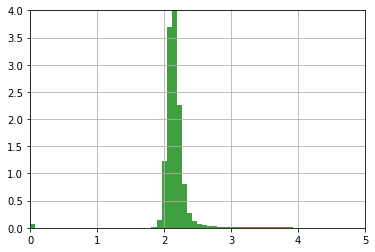

In [13]:
n, bins, patches = plt.hist(gainVec, bins=1000, density=True, facecolor='g', alpha=0.75)
plt.axis([0, 5, 0, 4])
plt.grid(True)
plt.show()

[]

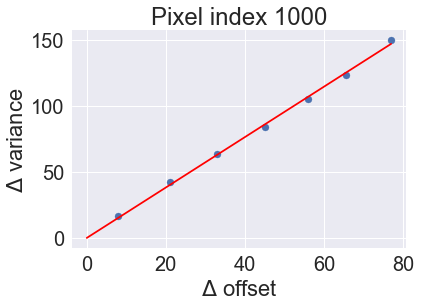

In [26]:
n_pixel = 1000 #np.where(gainVec>3)[0][0]
x = np.array([0, offsetVec[:, n_pixel].max()])
y = x * gainVec[n_pixel]
plt.scatter(offsetVec[:, n_pixel], varVec[:, n_pixel])
plt.plot(x, y, '-r')
plt.xlabel(r'$\Delta$ offset')
plt.ylabel(r'$\Delta$ variance')
plt.title('Pixel index %s'%(n_pixel))
# plt.axis([0, x.max()+1, 0, y.max()+1])
plt.plot()

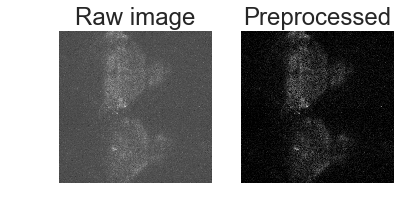

In [30]:
exImg = imgStack[0]
imgD = (exImg - offset) / (gain + 1e-12)
imgD[gain < 0.5] = 1e-6
# imgD[gain > 10] = 1e-6
imgD[imgD <= 0] = 1e-6
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(exImg, cmap='gray')
ax1.set_title('Raw image')
ax1.axis('off')
ax2.imshow(imgD, cmap='gray')
ax2.set_title('Preprocessed')
ax2.axis('off')
f.savefig('comparison.png', dpi=1000)
plt.show()

In [31]:
%%time
imgD = (exImg - offset) / (gain + 1e-12)
imgD[gain < 0.5] = 1e-6
# imgD[gain > 10] = 1e-6
imgD[imgD <= 0] = 1e-6

CPU times: user 40.1 ms, sys: 17 ms, total: 57.1 ms
Wall time: 55.7 ms


In [35]:
from pixelwiseDenoising.simpleDenioseTool import simpleDN
imgD_ = simpleDN(exImg, folder_name='/groups/ahrens/ahrenslab/Ziqiang/gainMat/gainMat20180208/')

# OTF
A diffraction limited imaging system has a cutoff frequency above which the higher frequency signal cannot be collected. The cutoff frequency is defined by the numerical aperture (NA), and the detection wavelength ($\lambda$), of the imaging system. The athors used this cutoff frequency to extract the noise part of the image. Aberrations in the microscope system might decrease the cutoff frequency which makes the use of theoretical cutoff a conservative approach. In the 2D Fourier transform of a microscopy image, the signal from the diffraction limited system is only contained in a circular region defined by the optical transfer function (OTF) of the imaging system. The OTF is the autocorrelation of the pupil function of the imaging system. For an ideal imaging system, the pupil radius is $\frac{NA}{\lambda}$, and the OTF radius is therefore two times of this quantity, $2\frac{NA}{\lambda}$.

noise contribution in 2D transformed image $U$ is calculated as

$\sigma = \sum_{k_x, k_y}|U(k_x, k_y)M(k_x, k_y)|$

## Parameters
* NA: numerical aperture of the objective
* $\lambda$: emission wavelength (micro-meter, um)
* $\Delta x = \Delta y$: pixel size (um) of the image in two dimensions, these are used to compute the 2D transform of the image, u(x, y) with L by L pixels as $U(k_x, k_y) = \frac{1}{L}\sum_x\sum_y u(x, y) \exp(-i2\pi k_x x)\exp(-i2\pi k_y y)$

## OTF mask
The OTF mask is implemented using a raised cosine filter defined by two parameters $\beta$ and $T$. 

$M(k_x, k_y) = 1$ if $k_r = \sqrt{k_x^2 + k_y^2}>\frac{1+\beta}{2T}$

$M(k_x, k_y) = 0$ if $k_r < \frac{1-\beta}{2T}$

$M(k_x, k_y) = \frac{1}{2} + \frac{1}{2}\cos[\frac{\pi T}{\beta}(k_r - \frac{1-\beta}{2T})]$ if otherwise

One can use one of the follow OTF masks:
1. OTF weighted mask (**default**; better peformance in denoising, but signal would be decreased, comparin to noise-only mask) $\beta = 1$, $T = \frac{\lambda}{4NA*1.4}$, 
2. Noise-only mask: $\beta = 0.2$, $T = \frac{(1-\beta)\lambda}{4NA}$, 
3. An adjustable version of weighted mask （using additional parameters like $w$ and $h$）: $\beta = \pi/2*\frac{k_{max}/w_0-1}{\arccos(1-2*h)+\pi/2*(k_{max}/w_0-1)}$, $T = \frac{1-\beta}{2w_0}$, $w_0 = w*\frac{NA}{\lambda}$


In [36]:
Pixelsize = 6.5 # pixel size is the property of the camera (make sure this value is correct)
Magnification = 16
Pixelsize = Pixelsize / Magnification
NA = 0.8 # numerical aperture of the objective
# emission should be changed according to the real experiment
Lambda = 0.500 # emission wavelength
w=1 # parameter for adjusted OTF
h=0.7 # parameter for adjusted OTF

In [37]:
import pixelwiseDenoising.denoisetools as ncs

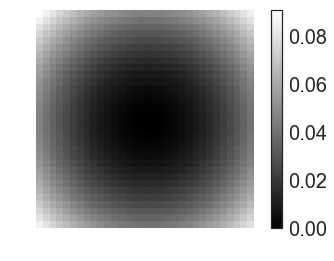

In [42]:
#OTF filter
OTFfilter = ncs.genfilter(M,Pixelsize,NA,Lambda,Type='OTFweighted',w=1,h=0.7)
plt.imshow(OTFfilter, cmap = plt.cm.gray)
plt.axis('off')
plt.colorbar()
plt.show()

In [43]:
alpha = 0.1 # weight factor of noise correction contribution vs LLS (simplified negative log likelihood function)
iterationN = 15 # number of iterations

In [45]:
# # optical transfer function filter is defined using filter type (default is OTFweighted), w and h
out = ncs.reducenoise(M, imgD_,var,gain,Pixelsize,NA,Lambda,alpha,iterationN)

Elapsed time for noise reduction: 921.981751203537


In [47]:
out[gain<0] = 1e-6
out_ = out
out_[gain<0.5] = 1e-6
imgD_[gain<0.5] = 1e-6

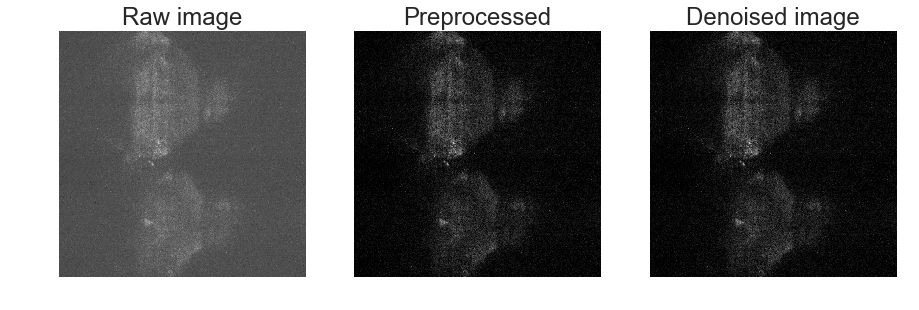

In [49]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(imgStack[0], cmap='gray')
# ax1.imshow(imgStack[0], cmap='gray')
ax1.set_title('Raw image')
ax1.axis('off')
ax2.imshow(imgD_, cmap='gray')
ax2.set_title('Preprocessed')
ax2.axis('off')
ax3.imshow(out_, cmap='gray')
ax3.set_title('Denoised image')
ax3.axis('off')
plt.show()

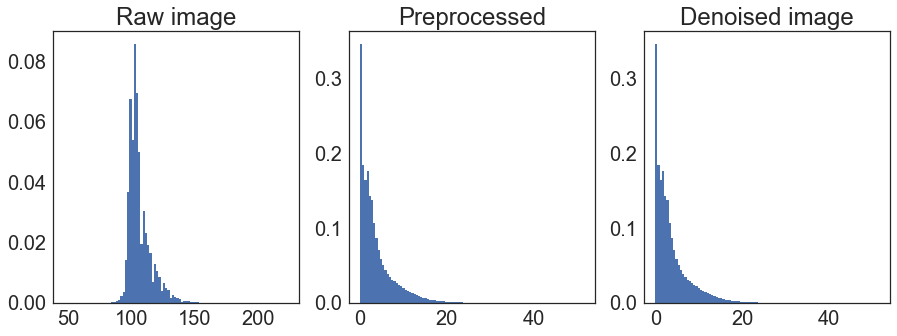

In [50]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.hist(exImg.reshape(-1), 100, density=True)
ax1.set_title('Raw image')
ax2.hist(imgD.reshape(-1), 100, density=True)
ax2.set_title('Preprocessed')
ax3.hist(out_.reshape(-1), 100, density=True)
ax3.set_title('Denoised image')
plt.show()

In [ ]:
# for alpha in [0, 0.1, 0.9, 9]:
#     out = ncs.reducenoise(M, imgD_,var_,gain_,Pixelsize,NA,Lambda,alpha,iterationN)
#     out[gain_<0] = 1e-6
#     out_ = out
#     out_[gain_<0.5] = 1e-6
#     plt.imshow(out_, cmap='gray')
#     plt.title(r'$\alpha$ = %0.1f'%alpha)
#     plt.show()
#     diff = np.abs(out_ - imgD_)/imgD_
#     print(diff.max())

## How is the denoised image compared to the one with preprocessing?

### Preprocessing imaging is defined as D

$D_i = (I_i - o_i)/\hat{g}_i$

### Comparison

1. compare the accumulated distribution between denoised image vs preprocessing image -- it has a visual difference at value ranged from 10 to 30

2. compare the relative change between denoised image vs preprocessing image at range from 10 to 30 -- relative change is defined as $|D_i - \hat{D}_i|/D_i$, which is quite small


In [ ]:
# out__ = out_[imgD_ > 0]
# imgD__ = imgD_[imgD_ > 0]
# values, base = np.histogram(out__, bins=1000)
# #evaluate the cumulative
# cumulative = np.cumsum(values)/len(out__)
# # plot the cumulative function
# plt.plot(base[:-1], cumulative, c='blue',label='denoised')
# values, base = np.histogram(imgD__, bins=1000)
# #evaluate the cumulative
# cumulative = np.cumsum(values)/len(imgD__)
# # plot the cumulative function
# plt.plot(base[:-1], cumulative, c='red',label='preprocessing')
# plt.xlabel('corrected pixel value')
# plt.ylabel('accumulated frac.')
# plt.legend()
# plt.show()

In [ ]:
# diff_ = diff[np.logical_and(imgD_ > 10, imgD_<30)]
# _, _, _ = plt.hist(diff_, 1000)
# plt.ylabel('counts')
# plt.xlabel('relative change')
# plt.show()